# 教程6: Galactic Binaries & RJMCMC


在第六篇教程中，我们将研究银河双星波形。然后我们将在固定维MCMC中使用它们，然后在RJMCMC中使用它们。我们使用RJMCMC对数据中的源数量进行模型选择。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *
from lisatools.sensitivity import get_sensitivity


## 任务1:使用`GBGPU`构建并绘制银河二进制波形

我们将从使用`GBGPU`生成银河二元波形开始。选择合理的参数，构建一个波形，并在特征应变表示中根据LISA a通道TDI灵敏度曲线(`A1TDISens`)绘制它。您可以在波形生成后作为类的属性访问信息。这可能在未来进行更新。

有用的文档:
* [GBGPU](https://mikekatz04.github.io/GBGPU/html/user/main.html#gbgpu.gbgpu.GBGPU)

In [2]:
# imports
from gbgpu.gbgpu import GBGPU

In [3]:
gb = GBGPU()

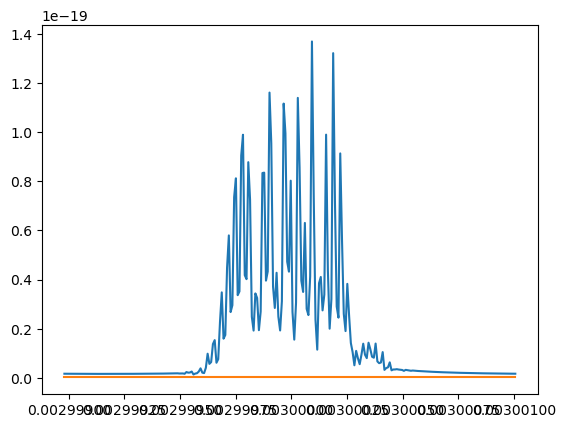

In [4]:
amp = 2e-23  # amplitude
f0 = 3e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
inc = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta = 0.5  # ecliptic latitude

Tobs = 4 * YRSID_SI
    
gb.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, N=256)  # T=Tobs, oversample=4)
plt.plot(gb.freqs[0], gb.freqs[0] * np.abs(gb.A[0]))
plt.plot(gb.freqs[0], get_sensitivity(gb.freqs[0], sens_fn="A1TDISens", return_type="char_strain"))


## 任务2:在单个GB源上运行MCMC

使用选定的GB源运行固定维度的MCMC。现在修复天空的位置，以简化计算问题(这对于下一节关于RJ与GBs的内容特别重要)。因此，你将对8个参数中的6个进行采样。讨论或思考这些参数的合理先验，以及您将如何确定它。为简单起见，我们建议在这个示例设置中使用紧密(但不太紧密)的均匀分布。

在`GBGPU`类中有一个更快的`get_ll`方法。然而，使用完整的`AnalysisContainer`设置可能更容易。这将使RJ部分更加直接，但实际上对于GBs上的固定维MCMC并不理想。

运行完成后，使用`chainconsumer`或`corner`绘制后验分布。

In [5]:
from eryn.prior import uniform_dist, ProbDistContainer
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray
from lisatools.sensitivity import AE1SensitivityMatrix
from eryn.ensemble import EnsembleSampler
from eryn.state import State

In [6]:
priors = {"gb": ProbDistContainer({
    0: uniform_dist(1e-23, 1e-21),
    1: uniform_dist(0.00299995, 0.00300005),
    2: uniform_dist(1e-18, 1e-17),
    3: uniform_dist(0.0, 2 * np.pi),
    4: uniform_dist(0.0, np.pi),  # should be over cosine of inclination, but this is simpler for examples
    5: uniform_dist(0.0, np.pi)
})}
lam = 4.13
beta = -0.15

# [lam, beta] of galactic center
default_values = np.array([lam, beta])
# 此处代码有更改 从上一个模块开始 第二行到第五行

In [7]:
N_wave = 256
def like_wrap(x, analysis1, data, fd, Tobs, dt, default_values):
    input_parameters = np.zeros(9)
    input_parameters[np.array([0, 1, 2, 4, 5, 6])] = x
    input_parameters[np.array([7, 8])] = default_values
    # print(input_parameters)
    gb.run_wave(*input_parameters, T=Tobs, dt=dt, N=N_wave)  # T=Tobs, oversample=4)
    
    A = gb.A[0]
    E = gb.E[0]
    # print(A[::100], check[0][::100])
    # print(gb.freqs[0][::100], check_freqs[::100])

    start_ind = int(gb.freqs[0][0] / df)
    template = DataResidualArray(np.array([A, E]), f_arr=gb.freqs[0])
    data_tmp = DataResidualArray(data[:, start_ind:start_ind + N_wave], f_arr=fd[start_ind:start_ind + N_wave])
    sens_mat = AE1SensitivityMatrix(data_tmp.f_arr)
    analysis = AnalysisContainer(data_tmp, sens_mat)
    # fig, ax = data_tmp.loglog()
    # print(data_tmp.shape)
    # plt.show()
    # template.loglog()
    # plt.show()
    ll = analysis.template_likelihood(template)
    return ll

In [8]:
injection_params = np.array([
    amp, 
    f0,
    fdot,
    0.0,
    phi0,
    inc,
    psi,
    lam,
    beta
])
print(injection_params)

Tobs = YRSID_SI
dt = 5.0
N = int(Tobs / dt)
Tobs = N * dt
df = 1 / Tobs
# TODO: fix DataREsidualArray frequency check error here with df=
f_arr = np.arange(0.0, 1/(2 * dt) + df, df)
data_orig = np.asarray(gb.inject_signal(*injection_params, T=Tobs, dt=dt, N=N_wave))
data = DataResidualArray(data_orig.copy(), f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data, sens_mat)

[ 2.000000e-23  3.000000e-03  7.538331e-18  0.000000e+00  1.000000e-01
  2.000000e-01  3.000000e-01  4.130000e+00 -1.500000e-01]


/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [9]:
sampling_injection_params = np.array([
    amp,
    f0,
    fdot,
    phi0,
    inc,
    psi
])
print(f0)
like_wrap(sampling_injection_params, analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values)

0.003


-0.0

In [10]:
ndims = {"gb": 6}
nwalkers = 24
ntemps = 10
sampler = EnsembleSampler(
    nwalkers,
    ndims, 
    like_wrap,
    priors,
    branch_names=["gb"],
    args=(analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values),
    tempering_kwargs=dict(ntemps=10),
    nleaves_max={"gb": 1},
)

In [11]:
start_state = State({"gb": priors["gb"].rvs(size=(ntemps, nwalkers, 1))})

In [12]:
nsteps = 2000
sampler.run_mcmc(start_state, nsteps, burn=1000, progress=True)

100%|██████████| 2000/2000 [03:48<00:00,  8.77it/s]


In [13]:
from chainconsumer import Chain, ChainConsumer
import pandas as pd

Parameter amp in chain 1 is not constrained
Parameter fdot in chain 1 is not constrained
Parameter phi0 in chain 1 is not constrained
Parameter psi in chain 1 is not constrained


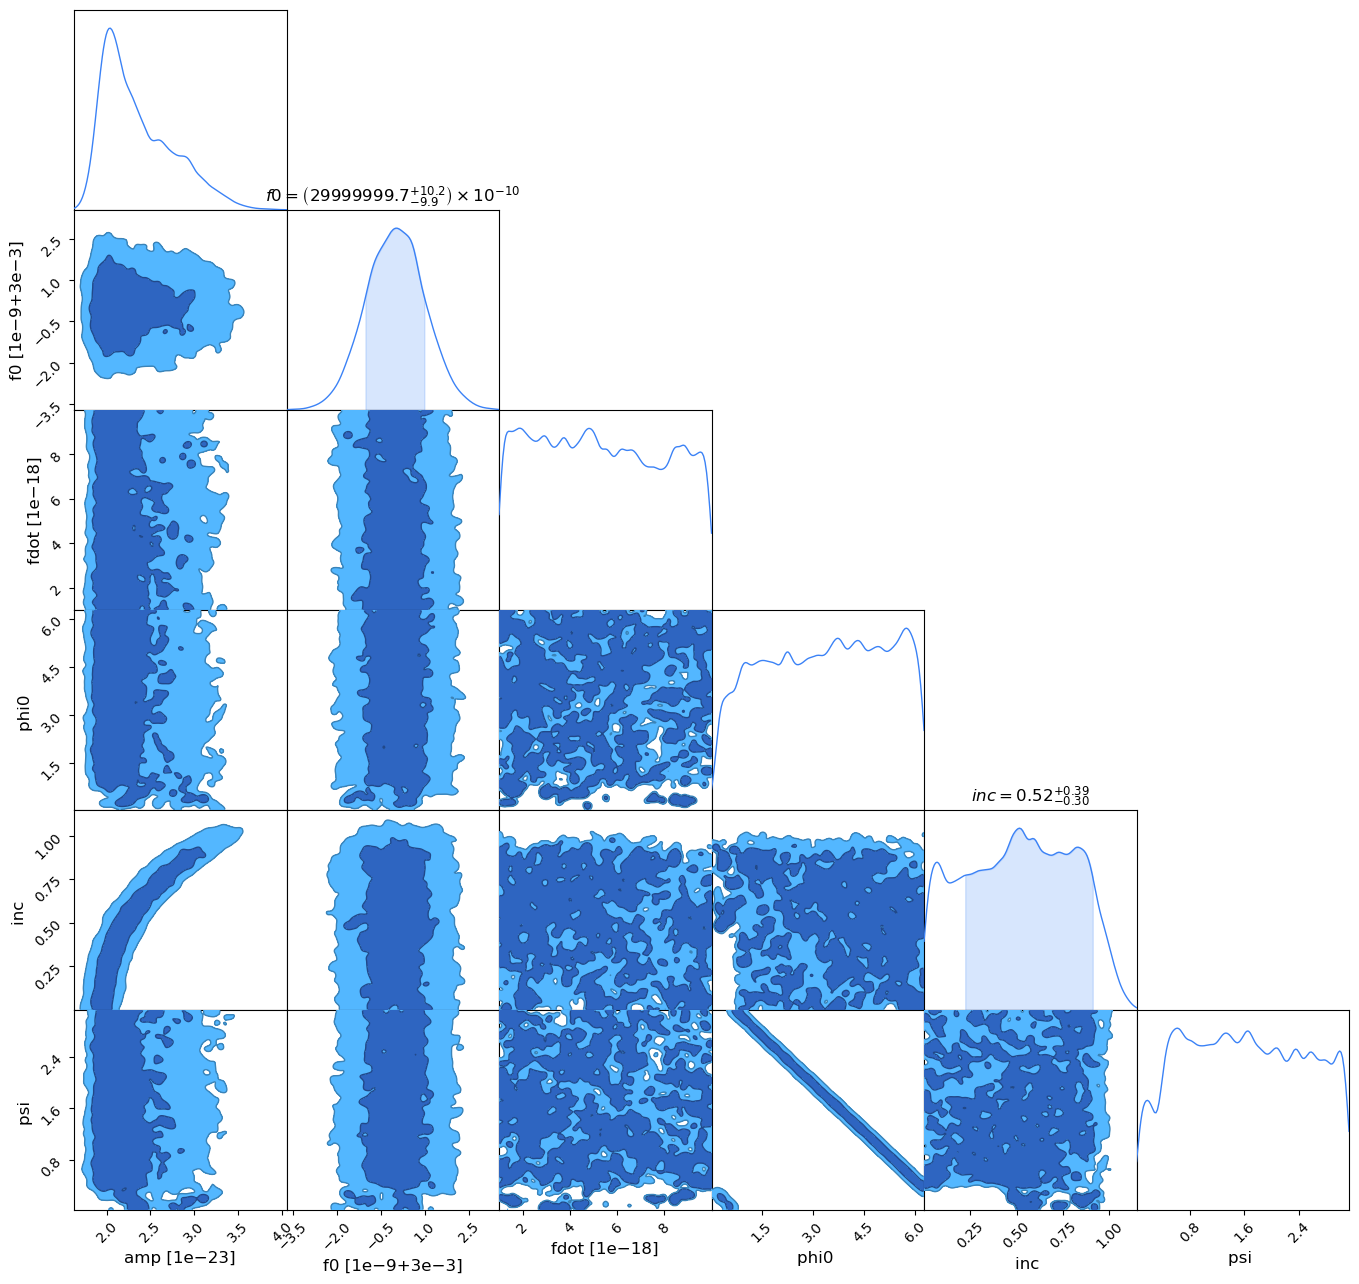

In [14]:
cold_chain = sampler.get_chain()["gb"][:, 0, :, 0].reshape(-1, 6)
c = ChainConsumer()

df1 = pd.DataFrame({name: val for name, val in zip(["amp", "f0", "fdot", "phi0", "inc", "psi"], cold_chain.T)}) 
c.add_chain(Chain(samples=df1, name=str(1)))
fig = c.plotter.plot()

## 任务3: RJ with GBs

我们的最后一个任务是在几个近距离的星系双星上运行RJMCMC。这里的关键部分是“全局”似然函数。构建一个函数，在进行似然计算之前，将Eryn和可调长度的模板数组累加到一个全局模板中。这可能有点乏味，但对理解这个过程非常重要。

在这个问题中，还有一个细微差别必须处理，以使这一切工作。在一个二进制的固定维度情况下，默认的拉伸建议有效地对每个维度的尺度不变，因为在创建建议时没有混合维度信息，$\vec{Y} = \vec{X}_j + z\left(\vec{X}_i - \vec{X}_j\right)$。我们在教程5中使用的默认`GaussianMove`需要对协方差矩阵求逆。如果我们对上面使用的参数进行采样($A$、$f_0$、$\dot{f}$等)，参数之间的尺度差异将导致矩阵求逆和乘法的数值问题。

有很多方法可以解决这个问题。有两种可能:

1) 您可以对每个参数进行对数缩放并缩小，使它们都是阶为1的。这需要改变先验信息，并确保将这种转换包含在似然函数中。你可以使用`eryn.utils `。如果你愿意，可以使用` TransformContainer`来进行转换。
2) 你可以创建自己的建议，假设协方差为对角线，并自己生成信息。在答案中，我在这个例子中选择了这种方式。**提示**:Eryn教程中有一个例子。

如果你真的想变得更花哨:

在上述设置中，每个当前具有`inds=True`的源将被移动到一起。这意味着，如果一个给定的walker有5个源，那么所有5个源的参数将同时改变。这可能会伤害这些动作的接受度。实际上，你可能希望使用吉布斯抽样一次性对一个或几个数据源进行抽样。你可以使用`eryn.moves.Move`的`gibbs＿sampling＿setup` kwarg来完成这一点。

有用的文档:

* [MHMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.MHMove)
* [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#eryn.utils.TransformContainer)
* [Move](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.Move)

如果你可以运行采样器并确认可能性是有效的，那么就可以认为这是完成的。为教程分配的时间和运行RJ设置所需的整体设置需要更多的运行时间才能得到合理的结果。因此，您可以绘制出结果，但随着采样器运行时间的延长，它将变得更加准确。

In [15]:
# imports
from eryn.moves import MHMove

In [16]:
def fill_template(template, A, E, freqs, Tobs, dt):
    for i in range(A.shape[0]):
        start_ind = gb.start_inds[i]
        end_ind = start_ind + N_wave
        
        assert end_ind - start_ind == gb.freqs.shape[1]
        template[0, start_ind:end_ind] += A[i]
        template[1, start_ind:end_ind] += E[i]

def generate_global_template(template, params_all, Tobs, dt):
    gb.run_wave(*params_all.T, T=Tobs, dt=dt, N=N_wave)  # Te=Tobs, oversample=4)
    fill_template(template, gb.A, gb.E, gb.freqs, Tobs, dt)
    
def global_log_likelihood(params_all, analysis, Tobs, dt, default_values):
    input_parameters = np.zeros((params_all.shape[0], 9))
    input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = params_all
    input_parameters[:, np.array([7, 8])] = default_values
    # print(input_parameters)
    
    template = np.zeros_like(analysis.data_res_arr[:])

    generate_global_template(template, input_parameters, Tobs, dt)
    template_in = DataResidualArray(template, f_arr=f_arr)
    ll = analysis.template_likelihood(template_in)
    return ll

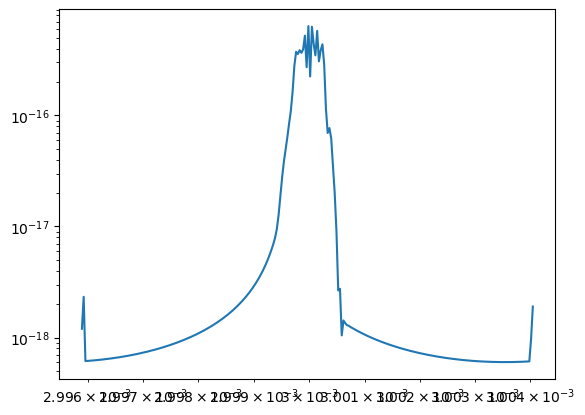

In [17]:
injection_params_all = priors["gb"].rvs(size=5)
input_parameters = np.zeros((injection_params_all.shape[0], 9))
input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = injection_params_all
input_parameters[:, np.array([7, 8])] = default_values
data = np.zeros((2, len(f_arr)), dtype=complex)

generate_global_template(data, input_parameters, Tobs, dt)
inds = np.where(data[0])
plt.loglog(f_arr[inds], np.abs(data[0][inds]))

In [18]:
data_arr = DataResidualArray(data, f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data_arr, sens_mat)

/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [19]:
class NonScaledDiagonalGaussianMove(MHMove):
    def __init__(self, cov_all, *args, **kwargs):

        for branch_name, cov in cov_all.items():
            assert isinstance(cov, np.ndarray) and cov.ndim == 1

        self.cov = cov_all
        super(NonScaledDiagonalGaussianMove, self).__init__(*args, **kwargs)
        
    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):

        assert branches_inds is not None
        new_points = {}
        for name, cov in self.cov.items():
            assert name in branches_coords
            coords = branches_coords[name]
            inds = branches_inds[name]
            
            ntemps, nwalkers, nleaves_max, ndim = coords.shape

            # generate sigma from normal distribution
            sigma = random.randn(ntemps, nwalkers)

            tmp = np.zeros_like(coords)

            tmp = coords + sigma[:, :, None, None] * cov[None, None, None, :]
            # symmetric
            new_points[name] = np.zeros_like(coords)

            # this is not necessary as the inds will remove there changes in the parent class
            # but I put it here to indicate to think about it
            new_points[name][inds] = tmp[inds]

        # symmetric
        factors = np.zeros((ntemps, nwalkers))
            
        return new_points, factors

In [20]:
nleaves_max = {"gb": 10}
nleaves_min = {"gb": 0}
ndims = {"gb": 6}

nwalkers = 14
ntemps = 12

lam = 4.13
beta = -0.15

# [lam, beta] of galactic center
default_values = np.array([lam, beta])

cov    = {"gb": np.array([1e-24, 1e-10, 1e-19, 0.01, 0.01, 0.01])}
moves = NonScaledDiagonalGaussianMove(cov)

sampler_rj = EnsembleSampler(
    nwalkers,
    ndims,
    global_log_likelihood,
    priors,
    branch_names=["gb"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    args=(analysis, Tobs, dt, default_values),
    rj_moves=True,
    moves=moves,
    tempering_kwargs=dict(ntemps=ntemps)
)

In [21]:
start_points = {"gb": priors["gb"].rvs(size=(ntemps, nwalkers, nleaves_max["gb"]))}
inds_tmp = np.zeros((ntemps, nwalkers, nleaves_max["gb"]), dtype=bool)
inds_tmp[:, :, 1] = True

start_state = State(start_points, inds={"gb": inds_tmp})

# lp = sampler_rj.compute_log_prior(start_state.branches_coords, inds=start_state.branches_inds)
# ll = sampler_rj.compute_log_like(start_state.branches_coords, inds=start_state.branches_inds, logp=lp)
# start_state.log_prior = lp
# start_state.log_like = ll

nsteps = 10
end_state = sampler_rj.run_mcmc(start_state, nsteps, progress=True)

100%|██████████| 10/10 [15:12<00:00, 91.29s/it]


# 学习总结和收获概述

## 教程内容概述：
1. 背景：研究银河双星波形，并使用这些波形在固定维度和可变维度的MCMC中进行分析（特别地，使用RJMCMC进行源数量的模型选择（承接教程5））
2. Pre：导入了必要的Python库，以及专门的LISA工具库。
## 学习总结：
在本教程中，我的学习如下：
1. 银河双星波形的研究：学习了如何生成和分析银河双星系统的波形数据
2. 固定维MCMC与RJMCMC的应用：如何在固定维度的MCMC中使用银河双星数据，并进一步在可变维度的MCMC（RJMCMC）中进行使用，以进行更复杂的模型选择和假设测试
3. 模型选择：如何使用RJMCMC对数据中存在的源数量进行模型选择
4. 耐心等待程序的运行，以及调研和学习了相关的计算模块以及如何计算和计算的相应时间，以及在前几个教程中接触到了加速运算的算法。通过7次教程的学习，本人对LISA数据分析这方面有了相应的初步了解。

## 写在最后：
本人在各种任务说明中不断摸索、不断请教、不断搜集信息，在这个过程中学习到了很多的代码知识，以及接触了很多关于代码的工具，激发了我对于相关代码学习的兴趣。“这是一片充满惊奇和未知的大海”，以作自勉与共勉。